In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install madgrad

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-m8im9pbm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-m8im9pbm
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=79e6501673a909946b0aedbdcdd64369e4a7eabe19d763a533b540798f2b2d43
  Stored in directory: /tmp/pip-ephem-wheel-cache-ntlx8ndg/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for madgrad: filename=madgrad-1.3-py3-none-any.whl size=11868 sha256=f95ad0f87ca992bf5f7d54aef02fb4c3149785fb31f900585906571f4386e213
  Stored 

In [2]:
import json
import os
from collections import Counter
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    MMBTConfig,
    MMBTForClassification,
    get_linear_schedule_with_warmup,
)
from madgrad import MADGRAD
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import clip
import pickle
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import copy

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)

100%|███████████████████████████████████████| 402M/402M [00:46<00:00, 9.04MiB/s]


In [6]:
for p in clip_model.parameters():
    p.requires_grad = False

In [7]:
image_embed_count = 4
gradient_accumulation_steps = 20
max_seq_length = 80 
max_grad_norm = 0.5
batch_size = 16
image_encoder_size = 288
image_features_size = 640
num_epochs = 10

In [8]:
def prepare_image(image, desired_size):
    image_resized = image.resize((desired_size, desired_size), Image.LANCZOS)
    image_array = np.array(image_resized)
    
    longer_dim = 0 if image_array.shape[0] > image_array.shape[1] else 1

    middle = image_array.shape[longer_dim] // 2
    start = middle - desired_size // 2
    end = start + desired_size

    if longer_dim == 0:
        image_slices = [Image.fromarray(image_array[:desired_size, :]), Image.fromarray(image_array[start:end, :]),
                  Image.fromarray(image_array[ar.shape[0] - desired_size:, :])]
    else:
        image_slices = [Image.fromarray(image_array[:, :desired_size]), Image.fromarray(image_array[:, start:end]),
                  Image.fromarray(image_array[:, image_array.shape[1] - desired_size:])]
    return image_slices

In [9]:
def process_image(image, desired_size):
    old_size = image.size
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    image = image.resize(new_size, Image.Resampling.LANCZOS)
    new_image = Image.new("RGB", (desired_size, desired_size))
    new_image.paste(image, ((desired_size-new_size[0])//2, (desired_size-new_size[1])//2))
    return new_image

In [10]:
class ClipEncoder(nn.Module):
    def __init__(self, num_embeds, num_features=image_features_size):
        super().__init__()        
        self.model = clip_model
        self.num_embeds = num_embeds
        self.num_features = num_features

    def forward(self, x):
        out = self.model.encode_image(x.view(-1, 3, 288, 288))
        out = out.view(-1, self.num_embeds, self.num_features).float()
        return out

In [11]:
class DatasetFromPaths(Dataset):
    def __init__(self, data_paths, tokenizer, transforms, max_seq_length):
        self.data = []
        for data_path in data_paths:
            self.data.extend([json.loads(l) for l in open(data_path)])
        self.data_dir = os.path.dirname(data_paths[0])  # Assuming all paths have the same directory
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = torch.LongTensor(self.tokenizer.encode(self.data[index]["text"], add_special_tokens=True))
        start_token, sentence, end_token = sentence[0], sentence[1:-1], sentence[-1]
        sentence = sentence[:self.max_seq_length]
        
        label = torch.FloatTensor([self.data[index]["label"]])
        
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        sliced_images = prepare_image(image, 288)
        sliced_images = [np.array(self.transforms(im)) for im in sliced_images]
        
        image = process_image(image, image_encoder_size)
        image = np.array(self.transforms(image))
        
        sliced_images = [image] + sliced_images
        sliced_images = torch.from_numpy(np.array(sliced_images)).to(device)
        
        return {
            "image_start_token": start_token,
            "image_end_token": end_token,
            "sentence": sentence,
            "image": sliced_images,
            "label": label
        }


In [12]:
def collate_fn(batch):
    lengths = [len(row["sentence"]) for row in batch]
    batch_size, max_seq_len = len(batch), max(lengths)
    
    mask = torch.zeros(batch_size, max_seq_len, dtype=torch.long)
    text = torch.zeros(batch_size, max_seq_len, dtype=torch.long)
    
    for i, (input, length) in enumerate(zip(batch, lengths)):
        text[i, :length] = input["sentence"]
        mask[i, :length] = 1
    
    image = torch.stack([row["image"] for row in batch])
    label = torch.stack([row["label"] for row in batch])
    
    image_start_token = torch.stack([row["image_start_token"] for row in batch])
    image_end_token = torch.stack([row["image_end_token"] for row in batch])
    
    return text, mask, image, image_start_token, image_end_token, label

In [13]:
# Load tokenizer
model_name = 'Hate-speech-CNERG/bert-base-uncased-hatexplain'#Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two'
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [14]:
input_path = "/kaggle/input/facebook-hateful-memes/hateful_memes/"

In [15]:
train_dataset = DatasetFromPaths([os.path.join(input_path, "train.jsonl")], tokenizer, preprocess, max_seq_length - image_embed_count - 2)
val_dataset = DatasetFromPaths([os.path.join(input_path, "dev_seen.jsonl"), os.path.join(input_path, "dev_unseen.jsonl")], tokenizer, preprocess, max_seq_length - image_embed_count - 2)

In [16]:
train_sampler = RandomSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)

train_dataloader = DataLoader(
        train_dataset,
        sampler=train_sampler,
        batch_size=batch_size,
        collate_fn=collate_fn
    )

val_dataloader = DataLoader(
        val_dataset, 
        sampler=val_sampler, 
        batch_size=batch_size, 
        collate_fn=collate_fn
    )

In [17]:
# Load model config and initialize model
text_encoder_config = AutoConfig.from_pretrained(model_name) 
text_encoder = AutoModel.from_pretrained(model_name, config=text_encoder_config)

image_encoder = ClipEncoder(image_embed_count )

mmbt_config = MMBTConfig(text_encoder_config, num_labels=1, modal_hidden_size=image_features_size)
model = MMBTForClassification(mmbt_config, text_encoder, image_encoder).to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [18]:
no_decay = ["bias", 
            "LayerNorm.weight"
           ]
weight_decay = 0.0005
optimizer_parameters = [
    {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": weight_decay},
    {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]
optimizer = MADGRAD(optimizer_parameters, lr=2e-4)

t_total = (len(train_dataloader) // gradient_accumulation_steps) * num_epochs
warmup_steps = t_total // 10

scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, t_total)
criterion = nn.BCEWithLogitsLoss()

In [19]:
model_path ="/kaggle/working/models/"

In [20]:
!mkdir -p models

In [21]:
def save_model(save_path, model, valid_loss):
    if save_path == None:
        return
    state_dict = {'state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print('Model saved!')

In [22]:
def get_evaluations(model, tokenizer, criterion, dataloader, tres = 0.5): 
    val_loss = 0.0
    val_steps = 0
    predictions = None
    probabilities = None
    output_labels = None
    
    for batch in dataloader:
        model.eval()
        batch = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            labels = batch[5]
            inputs = {
                "input_ids": batch[0],
                "input_modal": batch[2],
                "attention_mask": batch[1],
                "modal_start_tokens": batch[3],
                "modal_end_tokens": batch[4],
                "return_dict": False
            }
            outputs = model(**inputs)
            logits = outputs[0]
            
            tmp_val_loss = criterion(logits, labels)
            val_loss += tmp_val_loss.mean().item()
        
        val_steps += 1
        if predictions is None:
            predictions = torch.sigmoid(logits).detach().cpu().numpy() > tres
            probabilities = torch.sigmoid(logits).detach().cpu().numpy()
            output_labels = labels.detach().cpu().numpy()
        else:            
            predictions = np.append(predictions, torch.sigmoid(logits).detach().cpu().numpy() > tres, axis=0)
            probabilities = np.append(probabilities, torch.sigmoid(logits).detach().cpu().numpy(), axis=0)
            output_labels = np.append(output_labels, labels.detach().cpu().numpy(), axis=0)
    
    val_loss = val_loss / val_steps

    result = {
        "loss": val_loss,
        "accuracy": accuracy_score(output_labels, predictions),
        "AUC": roc_auc_score(output_labels, probabilities),
        "micro_f1": f1_score(output_labels, predictions, average="micro"),
        "prediction": predictions,
        "labels": output_labels,
        "probabilities": probabilities
    }
    
    return result

# Training

In [23]:
total_steps = 0
train_loss = 0.0
best_valid_auc = 0.70
steps_list = []
train_loss_list = []
val_loss_list = []
val_acc_list = []
val_auc_list = []
val_every = len(train_dataloader) // 7
cummulative_step_loss = 0

for i in range(num_epochs):
    for step, batch in enumerate(tqdm(train_dataloader)):
        model.train()
        batch = tuple(t.to(device) for t in batch)
        labels = batch[5]
        inputs = {
            "input_ids": batch[0],
            "input_modal": batch[2],
            "attention_mask": batch[1],
            "modal_start_tokens": batch[3],
            "modal_end_tokens": batch[4],
            "return_dict": False
        }
        outputs = model(**inputs)
        logits = outputs[0]
        loss = criterion(logits, labels)
        
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        
        loss.backward()
        train_loss += loss.item()
        cummulative_step_loss += loss.item()
        total_steps += 1
        
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        if (step + 1) % val_every == 0:
            average_train_loss = cummulative_step_loss / val_every
            train_loss_list.append(average_train_loss)
            steps_list.append(total_steps)
            cummulative_step_loss = 0.0
            
            val_result = get_evaluations(model, tokenizer, criterion, val_dataloader)
            val_loss_list.append(val_result['loss'])
            val_acc_list.append(val_result['accuracy'])
            val_auc_list.append(val_result['AUC'])
            
            if val_result['AUC'] > best_valid_auc:
                best_valid_auc = val_result['AUC']
                val_loss = val_result['loss']
                val_acc = val_result['accuracy']
                save_path = f'{model_path}/model-embs{image_embed_count }-seq{max_seq_length}-auc{best_valid_auc:.3f}-loss{val_loss:.3f}-acc{val_acc:.3f}.pt'
                print(f"AUC improved, so saving this model")  
                save_model(save_path, model, val_result['loss'])            
            print("Train loss:", f"{average_train_loss:.4f}", 
                  "Val loss:", f"{val_result['loss']:.4f}",
                  "Val acc:", f"{val_result['accuracy']:.4f}",
                  "AUC:", f"{val_result['AUC']:.4f}")

  0%|          | 0/532 [00:00<?, ?it/s]

Train loss: 0.0391 Val loss: 0.7240 Val acc: 0.4279 AUC: 0.5537
Train loss: 0.0352 Val loss: 0.6773 Val acc: 0.5721 AUC: 0.5678
Train loss: 0.0311 Val loss: 0.7087 Val acc: 0.5740 AUC: 0.5938
Train loss: 0.0295 Val loss: 0.7197 Val acc: 0.5952 AUC: 0.5860
Train loss: 0.0283 Val loss: 0.7577 Val acc: 0.6106 AUC: 0.6102
Train loss: 0.0283 Val loss: 0.7401 Val acc: 0.6010 AUC: 0.6143
Train loss: 0.0273 Val loss: 0.8768 Val acc: 0.5904 AUC: 0.6136


  0%|          | 0/532 [00:00<?, ?it/s]

Train loss: 0.0250 Val loss: 0.7063 Val acc: 0.6115 AUC: 0.6471
Train loss: 0.0228 Val loss: 0.7128 Val acc: 0.6279 AUC: 0.6665
Train loss: 0.0251 Val loss: 0.6946 Val acc: 0.6279 AUC: 0.6759
Train loss: 0.0234 Val loss: 0.6717 Val acc: 0.6308 AUC: 0.6765
Train loss: 0.0239 Val loss: 0.7346 Val acc: 0.6433 AUC: 0.6800
Train loss: 0.0227 Val loss: 0.7723 Val acc: 0.6385 AUC: 0.6715
Train loss: 0.0232 Val loss: 0.7760 Val acc: 0.6106 AUC: 0.6756


  0%|          | 0/532 [00:00<?, ?it/s]

Train loss: 0.0205 Val loss: 0.6966 Val acc: 0.6279 AUC: 0.6758
Train loss: 0.0188 Val loss: 0.8183 Val acc: 0.6385 AUC: 0.6773
AUC improved, so saving this model
Model saved!
Train loss: 0.0174 Val loss: 0.7608 Val acc: 0.6538 AUC: 0.7085
AUC improved, so saving this model
Model saved!
Train loss: 0.0189 Val loss: 0.8861 Val acc: 0.6192 AUC: 0.7263
Train loss: 0.0197 Val loss: 0.8386 Val acc: 0.6452 AUC: 0.7163
Train loss: 0.0184 Val loss: 0.7093 Val acc: 0.6827 AUC: 0.7195
Train loss: 0.0197 Val loss: 0.6944 Val acc: 0.6692 AUC: 0.7097


  0%|          | 0/532 [00:00<?, ?it/s]

Train loss: 0.0155 Val loss: 0.9402 Val acc: 0.6462 AUC: 0.7015
Train loss: 0.0148 Val loss: 0.9835 Val acc: 0.6490 AUC: 0.7022
Train loss: 0.0145 Val loss: 0.8536 Val acc: 0.6587 AUC: 0.7246
Train loss: 0.0140 Val loss: 0.9845 Val acc: 0.6558 AUC: 0.7192
Train loss: 0.0140 Val loss: 0.9044 Val acc: 0.6673 AUC: 0.7190
Train loss: 0.0153 Val loss: 0.7673 Val acc: 0.6683 AUC: 0.7122
Train loss: 0.0162 Val loss: 0.8146 Val acc: 0.6529 AUC: 0.7199


  0%|          | 0/532 [00:00<?, ?it/s]

Train loss: 0.0157 Val loss: 0.7702 Val acc: 0.6635 AUC: 0.7143
AUC improved, so saving this model
Model saved!
Train loss: 0.0143 Val loss: 0.7185 Val acc: 0.6577 AUC: 0.7358
Train loss: 0.0141 Val loss: 1.4306 Val acc: 0.6183 AUC: 0.6919
Train loss: 0.0155 Val loss: 0.7727 Val acc: 0.6548 AUC: 0.7307
Train loss: 0.0166 Val loss: 1.2285 Val acc: 0.6163 AUC: 0.7114
Train loss: 0.0142 Val loss: 0.7055 Val acc: 0.6615 AUC: 0.7318
Train loss: 0.0117 Val loss: 1.0776 Val acc: 0.6538 AUC: 0.7246


  0%|          | 0/532 [00:00<?, ?it/s]

Train loss: 0.0095 Val loss: 0.8204 Val acc: 0.6606 AUC: 0.7350
Train loss: 0.0084 Val loss: 1.0901 Val acc: 0.6644 AUC: 0.7229
Train loss: 0.0084 Val loss: 1.0094 Val acc: 0.6808 AUC: 0.7351
Train loss: 0.0088 Val loss: 1.0475 Val acc: 0.6769 AUC: 0.7336
Train loss: 0.0087 Val loss: 0.9444 Val acc: 0.6856 AUC: 0.7347
Train loss: 0.0095 Val loss: 1.0368 Val acc: 0.6529 AUC: 0.7329
Train loss: 0.0099 Val loss: 1.0341 Val acc: 0.6433 AUC: 0.7174


  0%|          | 0/532 [00:00<?, ?it/s]

Train loss: 0.0071 Val loss: 1.0512 Val acc: 0.6673 AUC: 0.7167
Train loss: 0.0077 Val loss: 1.1112 Val acc: 0.6692 AUC: 0.7135
Train loss: 0.0081 Val loss: 1.2063 Val acc: 0.6433 AUC: 0.7140
Train loss: 0.0067 Val loss: 1.3320 Val acc: 0.6490 AUC: 0.7146
Train loss: 0.0095 Val loss: 0.9459 Val acc: 0.6837 AUC: 0.7327
Train loss: 0.0071 Val loss: 1.3216 Val acc: 0.6442 AUC: 0.7217
Train loss: 0.0074 Val loss: 0.9871 Val acc: 0.6827 AUC: 0.7312


  0%|          | 0/532 [00:00<?, ?it/s]

Train loss: 0.0048 Val loss: 1.1591 Val acc: 0.6635 AUC: 0.7235
Train loss: 0.0038 Val loss: 1.2920 Val acc: 0.6721 AUC: 0.7155
Train loss: 0.0071 Val loss: 1.2101 Val acc: 0.6635 AUC: 0.7091
Train loss: 0.0075 Val loss: 1.4259 Val acc: 0.6615 AUC: 0.7150
Train loss: 0.0051 Val loss: 1.1944 Val acc: 0.6817 AUC: 0.7190
Train loss: 0.0063 Val loss: 1.3891 Val acc: 0.6452 AUC: 0.7184
Train loss: 0.0056 Val loss: 1.1001 Val acc: 0.6837 AUC: 0.7282


  0%|          | 0/532 [00:00<?, ?it/s]

Train loss: 0.0048 Val loss: 1.3260 Val acc: 0.6673 AUC: 0.7234
Train loss: 0.0036 Val loss: 1.0889 Val acc: 0.6837 AUC: 0.7313
Train loss: 0.0037 Val loss: 1.3282 Val acc: 0.6481 AUC: 0.7230
Train loss: 0.0042 Val loss: 1.3017 Val acc: 0.6548 AUC: 0.7243
Train loss: 0.0032 Val loss: 1.3424 Val acc: 0.6654 AUC: 0.7293
AUC improved, so saving this model
Model saved!
Train loss: 0.0043 Val loss: 1.2230 Val acc: 0.6990 AUC: 0.7369
AUC improved, so saving this model
Model saved!
Train loss: 0.0042 Val loss: 1.3982 Val acc: 0.6644 AUC: 0.7389


  0%|          | 0/532 [00:00<?, ?it/s]

AUC improved, so saving this model
Model saved!
Train loss: 0.0029 Val loss: 1.2238 Val acc: 0.6827 AUC: 0.7413
Train loss: 0.0024 Val loss: 1.3375 Val acc: 0.6779 AUC: 0.7355
Train loss: 0.0026 Val loss: 1.3115 Val acc: 0.6904 AUC: 0.7378
Train loss: 0.0029 Val loss: 1.4134 Val acc: 0.6846 AUC: 0.7325
Train loss: 0.0025 Val loss: 1.3823 Val acc: 0.6923 AUC: 0.7342
Train loss: 0.0032 Val loss: 1.3777 Val acc: 0.6856 AUC: 0.7353
Train loss: 0.0024 Val loss: 1.4215 Val acc: 0.6846 AUC: 0.7323


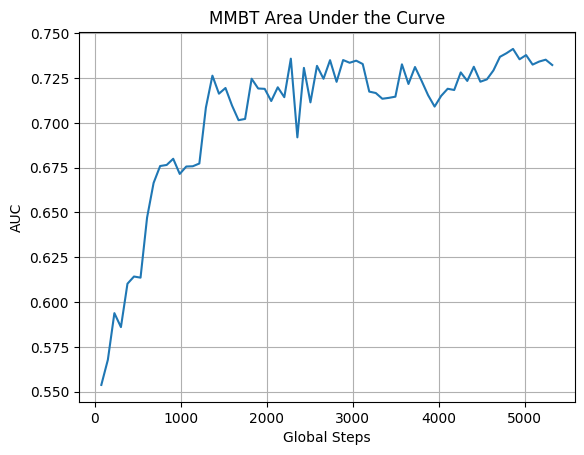

In [25]:
plt.plot(steps_list, val_auc_list)
plt.grid()
plt.xlabel('Global Steps')
plt.ylabel('AUC')
plt.title('MMBT Area Under the Curve')
plt.show()

# Testing

In [26]:
test_seen_dataset = DatasetFromPaths([os.path.join(input_path, "test_seen.jsonl")], tokenizer, preprocess, max_seq_length - image_embed_count  - 2)
test_unseen_dataset = DatasetFromPaths([os.path.join(input_path, "test_unseen.jsonl")], tokenizer, preprocess, max_seq_length - image_embed_count  - 2)

In [27]:
test_seen_sampler = SequentialSampler(test_seen_dataset)
test_unseen_sampler  = SequentialSampler(test_unseen_dataset)

test_seen_dataloader = DataLoader(
        test_seen_dataset,
        sampler=test_seen_sampler,
        batch_size=batch_size,
        collate_fn=collate_fn
    )


test_unseen_dataloader = DataLoader(
        test_unseen_dataset, 
        sampler=test_unseen_sampler, 
        batch_size=batch_size, 
        collate_fn=collate_fn
    )

In [28]:
test_seen_result = get_evaluations(model, tokenizer, criterion, test_seen_dataloader)
print("Test Seen loss:", f"{test_seen_result['loss']:.4f}", 
                  "Test Seen accuracy:", f"{test_seen_result['accuracy']:.4f}",
                  "Test Seen AUC:", f"{test_seen_result['AUC']:.4f}")

Test Seen loss: 1.3115 Test Seen accuracy: 0.6810 Test Seen AUC: 0.8041


In [29]:
test_unseen_result = get_evaluations(model, tokenizer, criterion, test_unseen_dataloader)
print("Test Unseen loss:", f"{test_unseen_result['loss']:.4f}", 
                  "Test Unseen accuracy:", f"{test_unseen_result['accuracy']:.4f}",
                  "Test Unseen AUC:", f"{test_unseen_result['AUC']:.4f}")

Test Unseen loss: 1.1199 Test Unseen accuracy: 0.7295 Test Unseen AUC: 0.7770


In [30]:
best_model_path = f'{model_path}/model-embs4-seq80-auc0.741-loss1.224-acc0.683.pt'

In [31]:
state_dict = torch.load(best_model_path, map_location=device)
best_model = MMBTForClassification(mmbt_config, text_encoder, image_encoder).to(device)
best_model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [32]:
test_seen_result = get_evaluations(best_model, tokenizer, criterion, test_seen_dataloader)
print("Test Seen loss:", f"{test_seen_result['loss']:.4f}", 
                  "Test Seen accuracy:", f"{test_seen_result['accuracy']:.4f}",
                  "Test Seen AUC:", f"{test_seen_result['AUC']:.4f}")

Test Seen loss: 1.1151 Test Seen accuracy: 0.6970 Test Seen AUC: 0.8009


In [33]:
test_unseen_result = get_evaluations(best_model, tokenizer, criterion, test_unseen_dataloader)
print("Test Unseen loss:", f"{test_unseen_result['loss']:.4f}", 
                  "Test Unseen accuracy:", f"{test_unseen_result['accuracy']:.4f}",
                  "Test Unseen AUC:", f"{test_unseen_result['AUC']:.4f}")

Test Unseen loss: 1.0092 Test Unseen accuracy: 0.7330 Test Unseen AUC: 0.7751
